In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
path = '../data/noise_removal'
train_path = f'{path}/train'
train_cleaned_path = f'{path}/train_cleaned'
test_path = f'{path}/test'

In [6]:
train_img = sorted(os.listdir(train_path))
train_cleaned_img = sorted(os.listdir(train_cleaned_path))
test_img = sorted(os.listdir(test_path))

In [7]:
def process_image(path):

    image = cv2.imread(path)
    image = np.asarray(image, dtype="float32")
    image = cv2.resize(image, (540, 420))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    image = np.reshape(image, (420, 540, 1))

    return image

def process_image_folder(folder_path):

    folder_images = sorted(os.listdir(folder_path))

    process_images = [
        process_image(folder_path + f'/{image}')
        for image in tqdm(folder_images)
    ]

    return process_images

In [8]:
train = process_image_folder(train_path)
train_cleaned = process_image_folder(train_cleaned_path)
test = process_image_folder(test_path)

100%|██████████| 72/72 [00:00<00:00, 136.03it/s]


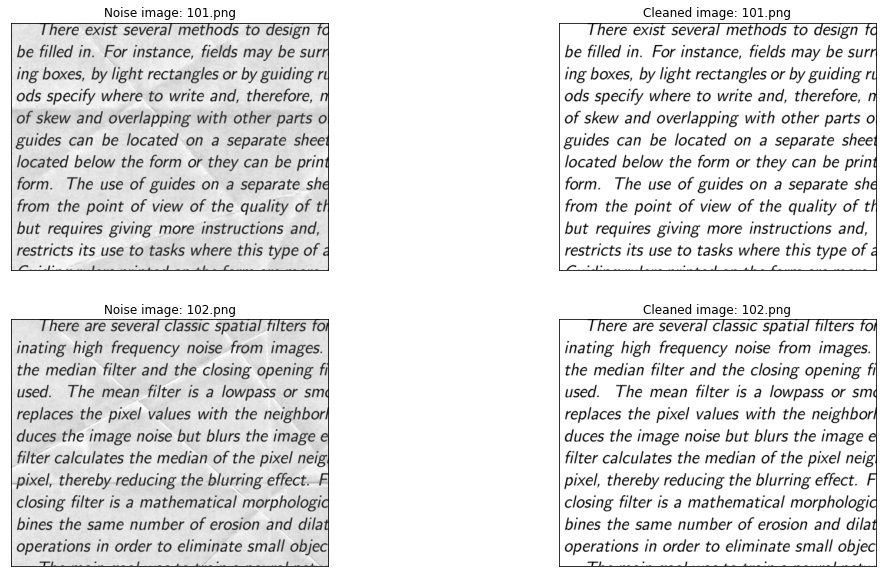

In [9]:
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))

image_idx = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j == 1:
            ax[i,j].imshow(train_cleaned[image_idx][:,:,0], cmap='gray')
            ax[i,j].set_title('Cleaned image: {}'.format(train_img[i]))
        else:
            ax[i,j].imshow(train[image_idx][:,:,0], cmap='gray')
            ax[i,j].set_title('Noise image: {}'.format(train_img[i]))

    image_idx += 1

In [10]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [11]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((122, 420, 540, 1), (22, 420, 540, 1), (122, 420, 540, 1), (22, 420, 540, 1))

In [15]:
class DenoisingModel:

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def encoder(self, input_layer):

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        # x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        encoded = tf.keras.layers.Dropout(0.5)(x)

        return encoded

    def decoder(self, encoded):

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        # x = tf.keras.layers.UpSampling2D((2, 2))(x)
        decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        return decoded

    def denoising(self):

        input_layer = tf.keras.layers.Input(shape=self.input_shape)

        encoded = encoder(input_layer)
        decoded = decoder(encoded)

        model = tf.keras.models.Model(
            inputs=[input_layer],
            outputs=[decoded]
        )
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae']
        )

        return model

def encoder(input_layer):

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = tf.keras.layers.Dropout(0.5)(x)

    return encoded

def decoder(x):

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return decoded

def denoising(input_shape=(420, 540, 1)):

    input_layer = tf.keras.layers.Input(shape=input_shape)

    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    model = tf.keras.models.Model(
        inputs=[input_layer],
        outputs=[decoded]
    )
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [16]:
model = denoising()

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 420, 540, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 210, 270, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 210, 270, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 105, 135, 128)    0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 105, 135, 128)    512 

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=12,
    callbacks=[callback]
)

Epoch 1/100
 5/11 [============>.................] - ETA: 55s - loss: 0.2048 - mae: 0.3368 

KeyboardInterrupt: 

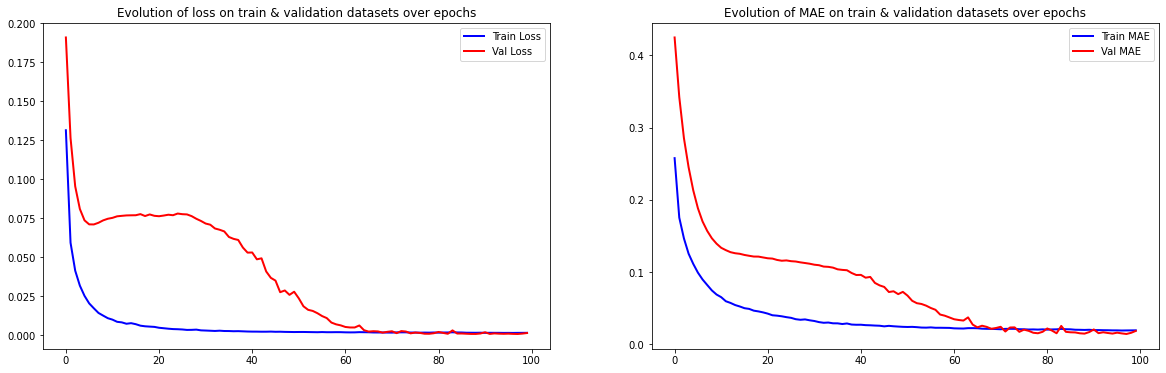

In [36]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


In [37]:
test_cleaned = model.predict(X_test, batch_size=12)

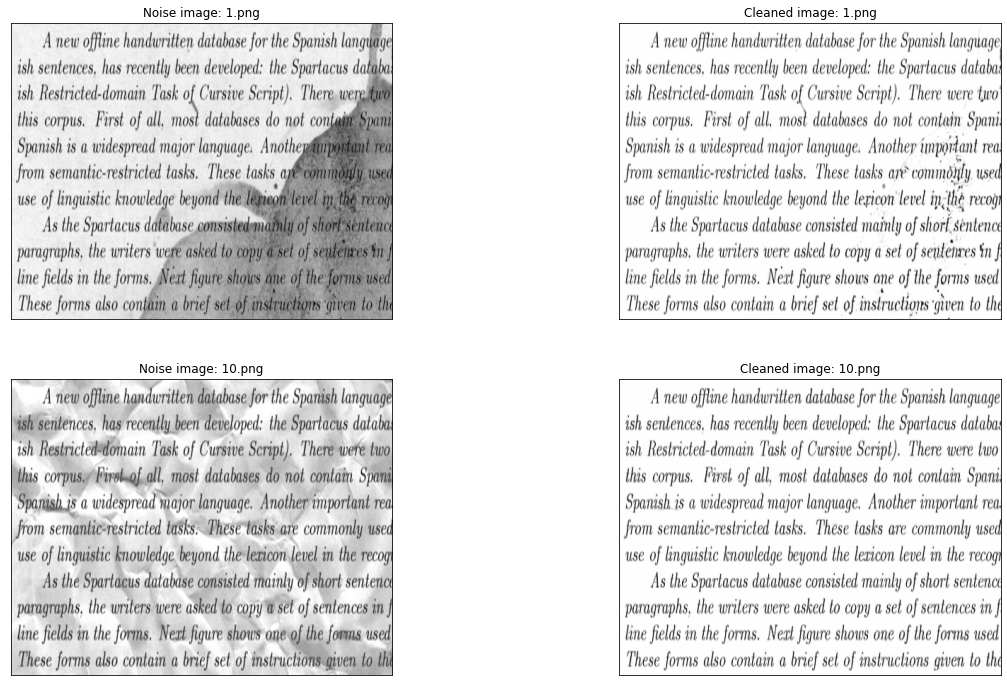

In [49]:
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))

image_idx = 0
for i in range(nrows):
    for j in range(ncols):
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      if j == 1:
          ax[i,j].imshow(test_cleaned[image_idx][:,:,0], cmap='gray')
          ax[i,j].set_title('Cleaned image: {}'.format(test_img[i]))
      else:
          ax[i,j].imshow(test[image_idx][:,:,0], cmap='gray')
          ax[i,j].set_title('Noise image: {}'.format(test_img[i]))

    image_idx += 1